In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [3]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [4]:
flx = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw.nc')
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_heat.nc')
flx['heat'] = nc.heat

In [5]:
flx_fw_spna_north = -flx.fw.sel(section='Denmark Strait') - flx.fw.sel(section='Iceland Faroe') \
                    - flx.fw.sel(section='Faroe Scotland')
flx_ht_spna_north = -flx.heat.sel(section='Denmark Strait') - flx.heat.sel(section='Iceland Faroe') \
                    - flx.heat.sel(section='Faroe Scotland')

In [6]:
flx_fw_nsea_north = -flx.fw.sel(section='Fram Strait')# - flx.fw.sel(section='Barents Sea')
flx_fw_nsea_south = flx.fw.sel(section='Denmark Strait') + flx.fw.sel(section='Iceland Faroe') \
                    + flx.fw.sel(section='Faroe Scotland')# + flx.fw.sel(section='Scotland Norway')

flx_ht_nsea_north = -flx.heat.sel(section='Barents Sea')# - flx.heat.sel(section='Fram Strait') 
flx_ht_nsea_south = flx.heat.sel(section='Denmark Strait') + flx.heat.sel(section='Iceland Faroe') \
                    + flx.heat.sel(section='Faroe Scotland')# + flx.heat.sel(section='Scotland Norway')

In [7]:
flx_bnd = xr.concat([flx_fw_spna_north, flx_ht_spna_north, flx_fw_nsea_north, flx_fw_nsea_south, 
                     flx_ht_nsea_north, flx_ht_nsea_south], 
                    pd.Index(['fw_north_spna','ht_north_spna','fw_north_nsea','fw_south_nsea',
                              'ht_north_nsea','ht_south_nsea'], name='term')).reset_coords(drop=True)

### Seasonal anomalies

In [8]:
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
flx_anom = flx.groupby('time.month') - flx.groupby('time.month').mean('time')

flx_anom = flx.groupby('time.month') - flx.groupby('time.month').mean('time')
flx_bnd_anom = flx_bnd.groupby('time.month') - flx_bnd.groupby('time.month').mean('time')

### Integrate anomalies

In [9]:
budgFw_int = (budgFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

flx_int = (flx_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
flx_int['time'] = ecco.time.isel(time=slice(1, -1))

flx_bnd_int = (flx_bnd_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

In [10]:
budgFw_int = budgFw_int.sel(time=slice('1993-01-01','2015-12-31'))
budgH_int = budgH_int.sel(time=slice('1993-01-01','2015-12-31'))
flx_int = flx_int.sel(time=slice('1993-01-01','2015-12-31'))
flx_bnd_int = flx_bnd_int.sel(time=slice('1993-01-01','2015-12-31'))

### Anomalies (from the mean)

In [11]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
budgH_anom = budgH_int - budgH_int.mean('time')
flx_anom = flx_int - flx_int.mean('time')
flx_bnd_anom = flx_bnd_int - flx_bnd_int.mean('time')

### Plot

In [12]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


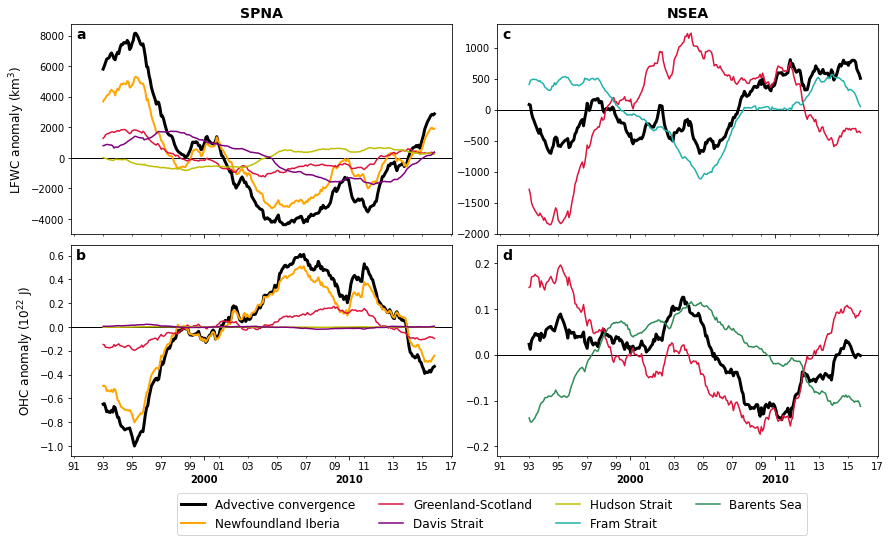

In [13]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_ConvFw')*1e-3, lw=3, color='k',
              label='Advective convergence')
axs[0,0].plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').fw*1e-3, lw=2, color='orange',
              label='Newfoundland Iberia')
axs[0,0].plot(flx_bnd_anom.time, flx_bnd_anom.sel(term='fw_north_spna')*1e-3, lw=1.5, color='crimson',
              label='Greenland-Scotland')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').fw*1e-3, lw=1.5, color='y',
              label='Hudson Strait')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').fw*1e-3, lw=1.5, color='purple',
              label='Davis Strait')
axs[0,0].set_ylabel(r'LFWC anomaly (km$^3$)',fontsize=12)
axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'SPNA', fontsize=14, fontweight='bold')

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_ConvH')*1e-22, lw=3, color='k',
              label='Advective convergence')
axs[1,0].plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').heat*1e-7,lw=2,color='orange',
              label='Newfoundland Iberia')
axs[1,0].plot(flx_bnd_anom.time, flx_bnd_anom.sel(term='ht_north_spna')*1e-7, lw=1.5, color='crimson',
              label='Greenland-Scotland')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').heat*1e-7, lw=1.5, color='y',
              label='Hudson Strait')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').heat*1e-7, lw=1.5, color='purple',
              label='Davis Strait')
axs[1,0].set_ylabel(r'OHC anomaly (10$^{22}$ J)', fontsize=12)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_ConvFw')*1e-3, lw=3, color='k',
              label='Advective convergence')
axs[0,1].plot(flx_bnd_anom.time, flx_bnd_anom.sel(term='fw_south_nsea')*1e-3, lw=1.5, color='crimson',
              label='Greenland-Scotland')
axs[0,1].plot(flx_bnd_anom.time, flx_bnd_anom.sel(term='fw_north_nsea')*1e-3, lw=1.5, color='lightseagreen',
              label='Fram Strait')
axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'NSEA', fontsize=14, fontweight='bold')

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_ConvH')*1e-22, lw=3, color='k',
              label='Advective convergence')
axs[1,1].plot(flx_bnd_anom.time, flx_bnd_anom.sel(term='ht_south_nsea')*1e-7, lw=1.5, color='crimson',
              label='Greenland-Scotland')
axs[1,1].plot(flx_bnd_anom.time, flx_bnd_anom.sel(term='ht_north_nsea')*1e-7, lw=1.5, color='seagreen',
              label='Barents Sea')
axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

# Add lines outlide of plot for legend
axs[1,1].plot(flx.time[:2], [-1,-1], lw=2,color='orange',label='Newfoundland Iberia')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='purple',label='Davis Strait')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='y',label='Hudson Strait')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5,color='lightseagreen',label='Fram Strait')

axs[1,1].set_ylim([-0.22,0.24])

handles, labels = axs[1,1].get_legend_handles_labels()
order = [0,3,1,4,5,6,2]
axs[1,1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                frameon=True, fancybox=True, bbox_to_anchor=(0.83, -0.15), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


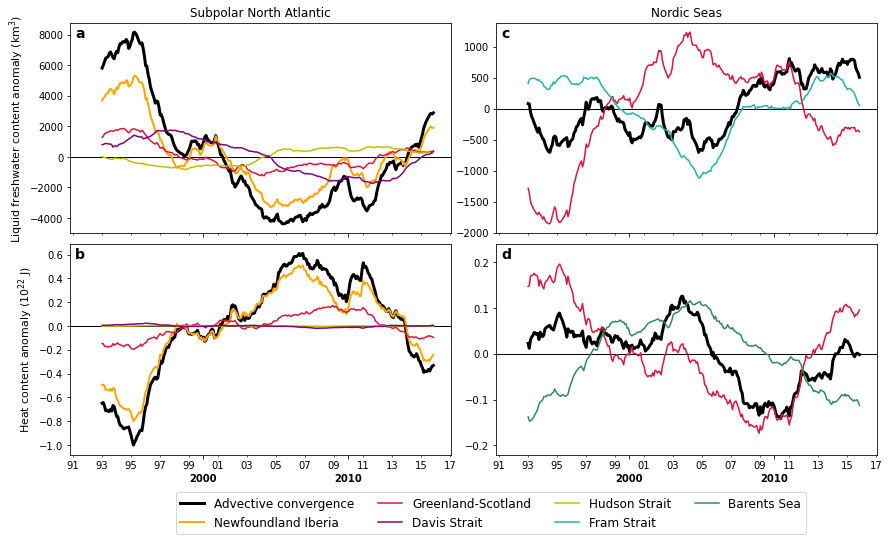

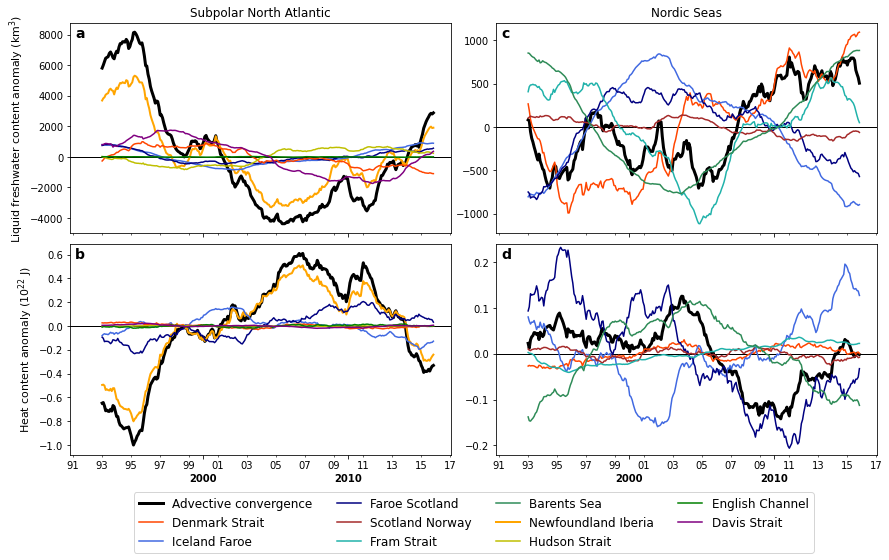

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


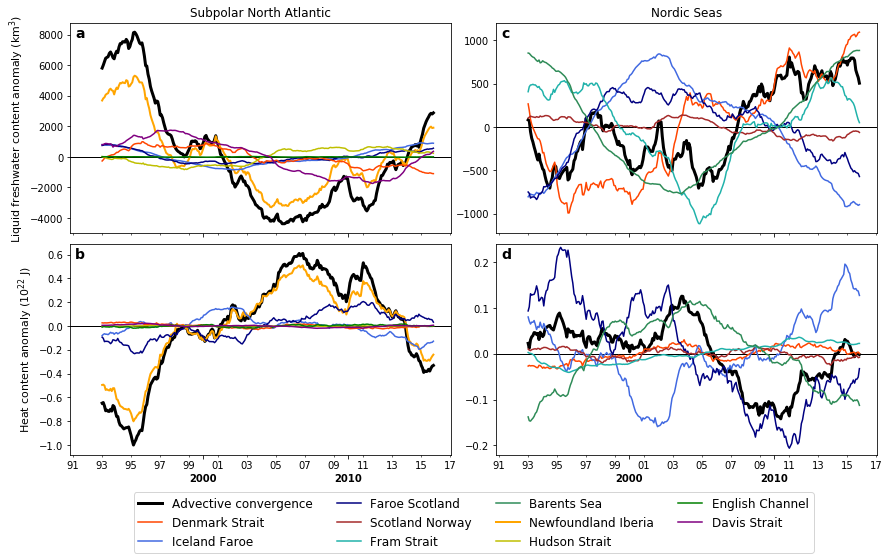

In [16]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_ConvFw')*1e-3, lw=3, color='k',
              label='Advective convergence')
axs[0,0].plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').fw*1e-3, lw=2, color='orange',
              label='Newfoundland Iberia')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Iceland Faroe').fw*1e-3, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Faroe Scotland').fw*1e-3, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Denmark Strait').fw*1e-3, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').fw*1e-3, lw=1.5, color='y',
              label='Hudson Strait')
axs[0,0].plot(flx_anom.time, flx_anom.sel(section='English Channel').fw*1e-3, lw=1.5, color='g',
              label='English Channel')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').fw*1e-3, lw=1.5, color='purple',
              label='Davis Strait')
axs[0,0].set_ylabel(r'Liquid freshwater content anomaly (km$^3$)',fontsize=11)
axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'Subpolar North Atlantic', fontsize=12)

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_ConvH')*1e-22, lw=3, color='k',
              label='Advective convergence')
axs[1,0].plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').heat*1e-7,lw=2,color='orange',
              label='Newfoundland Iberia')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Iceland Faroe').heat*1e-7, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Faroe Scotland').heat*1e-7, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Denmark Strait').heat*1e-7, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').heat*1e-7, lw=1.5, color='y',
              label='Hudson Strait')
axs[1,0].plot(flx_anom.time, flx_anom.sel(section='English Channel').heat*1e-7, lw=1.5, color='g',
              label='English Channel')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').heat*1e-7, lw=1.5, color='purple',
              label='Davis Strait')
axs[1,0].set_ylabel(r'Heat content anomaly (10$^{22}$ J)', fontsize=11)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_ConvFw')*1e-3, lw=3, color='k',
              label='Advective convergence')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Denmark Strait').fw*1e-3, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Iceland Faroe').fw*1e-3, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Faroe Scotland').fw*1e-3, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Scotland Norway').fw*1e-3, lw=1.5, color='brown',
              label='Scotland Norway')
axs[0,1].plot(flx_anom.time, -flx_anom.sel(section='Fram Strait').fw*1e-3, lw=1.5, color='lightseagreen',
              label='Fram Strait')
axs[0,1].plot(flx_anom.time, -flx_anom.sel(section='Barents Sea').fw*1e-3, lw=1.5, color='seagreen',
              label='Barents Sea')
axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'Nordic Seas', fontsize=12)

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_ConvH')*1e-22, lw=3, color='k',
              label='Advective convergence')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Denmark Strait').heat*1e-7, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Iceland Faroe').heat*1e-7, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Faroe Scotland').heat*1e-7, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Scotland Norway').heat*1e-7, lw=1.5, color='brown',
              label='Scotland Norway')
axs[1,1].plot(flx_anom.time, -flx_anom.sel(section='Fram Strait').heat*1e-7, lw=1.5, color='lightseagreen',
              label='Fram Strait')
axs[1,1].plot(flx_anom.time, -flx_anom.sel(section='Barents Sea').heat*1e-7, lw=1.5, color='seagreen',
              label='Barents Sea')
axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

# Add lines outlide of plot for legend
axs[1,1].plot(flx.time[:2], [-1,-1],lw=2,color='orange',label='Newfoundland Iberia')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='y',label='Hudson Strait')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='g',label='English Channel')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='purple',label='Davis Strait')
axs[1,1].set_ylim([-0.22,0.24])

axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.85, -0.15), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


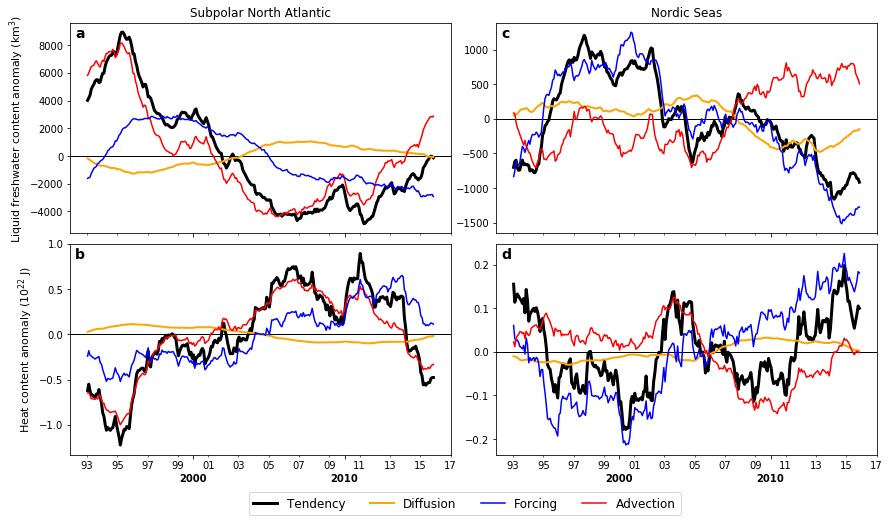

In [21]:
import datetime

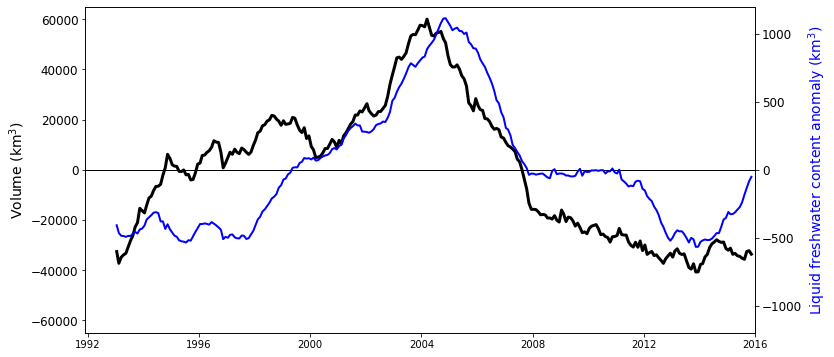

In [28]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(flx_anom.time, flx_anom.sel(section='Fram Strait').vol*1e-3, lw=3, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax1.set_ylim([-6.5e4,6.5e4])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Volume (km$^3$)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(flx_anom.time, flx_anom.sel(section='Fram Strait').fw*1e-3, lw=2, color='blue',label='Freshwater')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax2.set_ylim([-1200,1200])
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Liquid freshwater content anomaly (km$^3$)', color='b', fontsize=14)


plt.show()

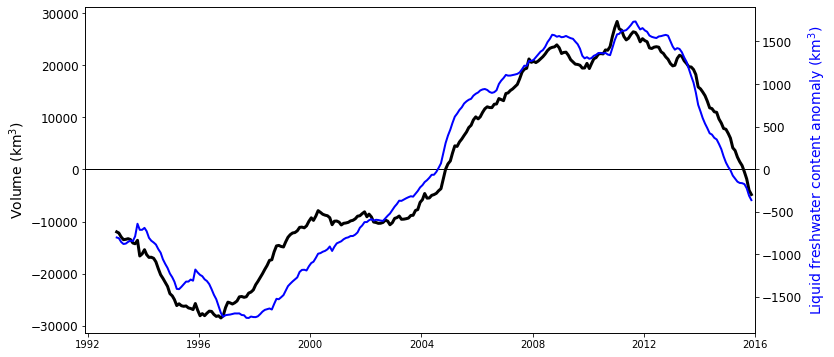

In [29]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(flx_anom.time, flx_anom.sel(section='Davis Strait').vol*1e-3, lw=3, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Volume (km$^3$)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(flx_anom.time, flx_anom.sel(section='Davis Strait').fw*1e-3, lw=2, color='blue',label='Freshwater')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax2.set_ylim([-1200,1200])
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Liquid freshwater content anomaly (km$^3$)', color='b', fontsize=14)


plt.show()

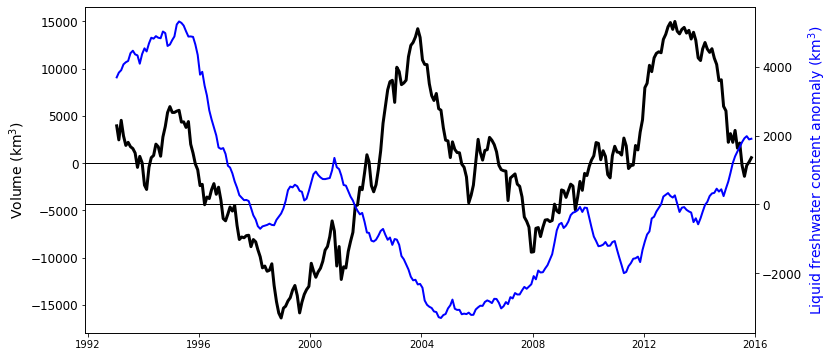

In [30]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').vol*1e-3, lw=3, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Volume (km$^3$)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').fw*1e-3, lw=2, color='blue',label='Freshwater')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax2.set_ylim([-1200,1200])
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Liquid freshwater content anomaly (km$^3$)', color='b', fontsize=14)


plt.show()

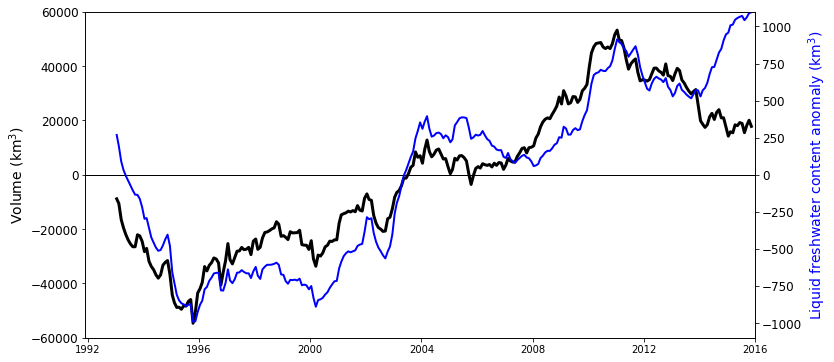

In [32]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(flx_anom.time, flx_anom.sel(section='Denmark Strait').vol*1e-3, lw=3, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax1.set_ylim([-6e4,6e4])
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('Volume (km$^3$)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(flx_anom.time, flx_anom.sel(section='Denmark Strait').fw*1e-3, lw=2, color='blue',label='Freshwater')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax2.set_ylim([-1100,1100])
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_ylabel(r'Liquid freshwater content anomaly (km$^3$)', color='b', fontsize=14)


plt.show()